In [1]:
import tensorflow as tf
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [72]:
df = yf.download("^GSPC", interval = "1wk", start = "2000-01-01")

[*********************100%%**********************]  1 of 1 completed


In [73]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-01,1469.250000,1478.000000,1377.680054,1441.469971,1441.469971,5343800000
2000-01-08,1441.469971,1473.000000,1427.079956,1465.150024,1465.150024,5169700000
2000-01-15,1465.150024,1465.709961,1438.540039,1441.359985,1441.359985,4455000000
2000-01-22,1441.359985,1454.089966,1356.199951,1360.160034,1360.160034,5532100000
2000-01-29,1360.160034,1435.910034,1350.140015,1424.369995,1424.369995,5205000000


In [74]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [76]:
lookback = 30

x_train = []
y_train = []
for i in range(len(df)-lookback):
  x_train.append(scaled_data[i:i+lookback,0])
  y_train.append(scaled_data[i+lookback,0])

In [77]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [78]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [79]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(x_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

In [80]:
model.compile(optimizer="adam", loss='mean_squared_error')

In [81]:
model.fit(x_train, y_train, epochs=25, batch_size = 24)

Epoch 1/25
52/52 [==============================] - 13s 158ms/step - loss: 0.0359
Epoch 2/25
52/52 [==============================] - 7s 137ms/step - loss: 0.0058
Epoch 3/25
52/52 [==============================] - 8s 160ms/step - loss: 0.0055
Epoch 4/25
52/52 [==============================] - 8s 154ms/step - loss: 0.0041
Epoch 5/25
52/52 [==============================] - 7s 137ms/step - loss: 0.0040
Epoch 6/25
52/52 [==============================] - 8s 158ms/step - loss: 0.0035
Epoch 7/25
52/52 [==============================] - 8s 151ms/step - loss: 0.0043
Epoch 8/25
52/52 [==============================] - 8s 147ms/step - loss: 0.0032
Epoch 9/25
52/52 [==============================] - 8s 156ms/step - loss: 0.0035
Epoch 10/25
52/52 [==============================] - 7s 139ms/step - loss: 0.0032
Epoch 11/25
52/52 [==============================] - 8s 159ms/step - loss: 0.0029
Epoch 12/25
52/52 [==============================] - 8s 160ms/step - loss: 0.0027
Epoch 13/25
52/52 [=====

In [ ]:
predictions = []
for i in range(len(df)):
  try:
    predict_x = x_train[i]
    prediction = scaler.inverse_transform(model.predict(np.reshape(predict_x, (1,predict_x.shape[0],1))))[0][0]
    true_value = scaler.inverse_transform(np.array(y_train[i].reshape(1,-1)))[0][0]
    predictions.append([prediction, true_value])

  except:
    pass

In [83]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = ['predicted','true']

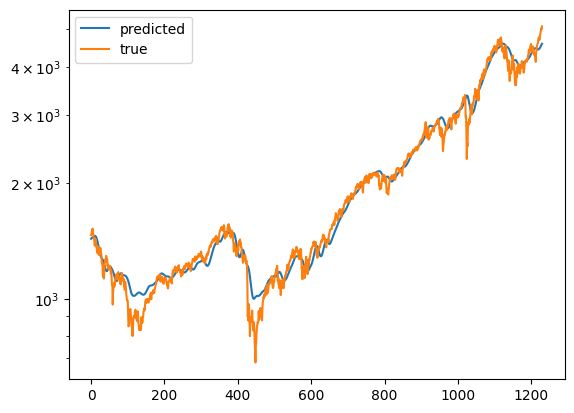

In [84]:
predictions_df.plot()
plt.yscale("log")

In [90]:
predictions_df['day_close'] = predictions_df['true'].shift()
predictions_df['position'] = np.where(predictions_df['predicted']>predictions_df['day_close'], 1, 0)
predictions_df['ret'] = predictions_df['true']/predictions_df['true'].shift()
predictions_df['strat_ret'] = predictions_df['ret'] * predictions_df['position']
predictions_df['strat_ret'][predictions_df['strat_ret'] == 0] = ((1.06)**(1/250))
predictions_df['strat_nav'], predictions_df['nav'] = predictions_df['strat_ret'].cumprod(), predictions_df['ret'].cumprod()

<ipython-input-90-c9243cb27848>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_df['strat_ret'][predictions_df['strat_ret'] == 0] = ((1.06)**(1/250))


In [91]:
predictions_df

,predicted,true,day_close,position,ret,strat_ret,strat_nav,nav
0,1431.134644,1462.930054,NaN,0,NaN,NaN,NaN,NaN
1,1434.469238,1471.839966,1462.930054,0,1.006090,1.000233,1.000233,1.006090
2,1437.730957,1491.719971,1471.839966,0,1.013507,1.000233,1.000466,1.019680
3,1440.520630,1506.449951,1491.719971,0,1.009874,1.000233,1.000699,1.029748
4,1442.628662,1520.770020,1506.449951,0,1.009506,1.000233,1.000933,1.039537
...,...,...,...,...,...,...,...,...
1225,4508.090332,4890.970215,4839.810059,0,1.010571,1.000233,5.349386,3.343270
1226,4526.825684,4958.609863,4890.970215,0,1.013829,1.000233,5.350633,3.389506
1227,4546.969238,5026.609863,4958.609863,0,1.013714,1.000233,5.351881,3.435988
1228,4567.587891,5005.569824,5026.609863,0,0.995814,1.000233,5.353128,3.421606


<Axes: >

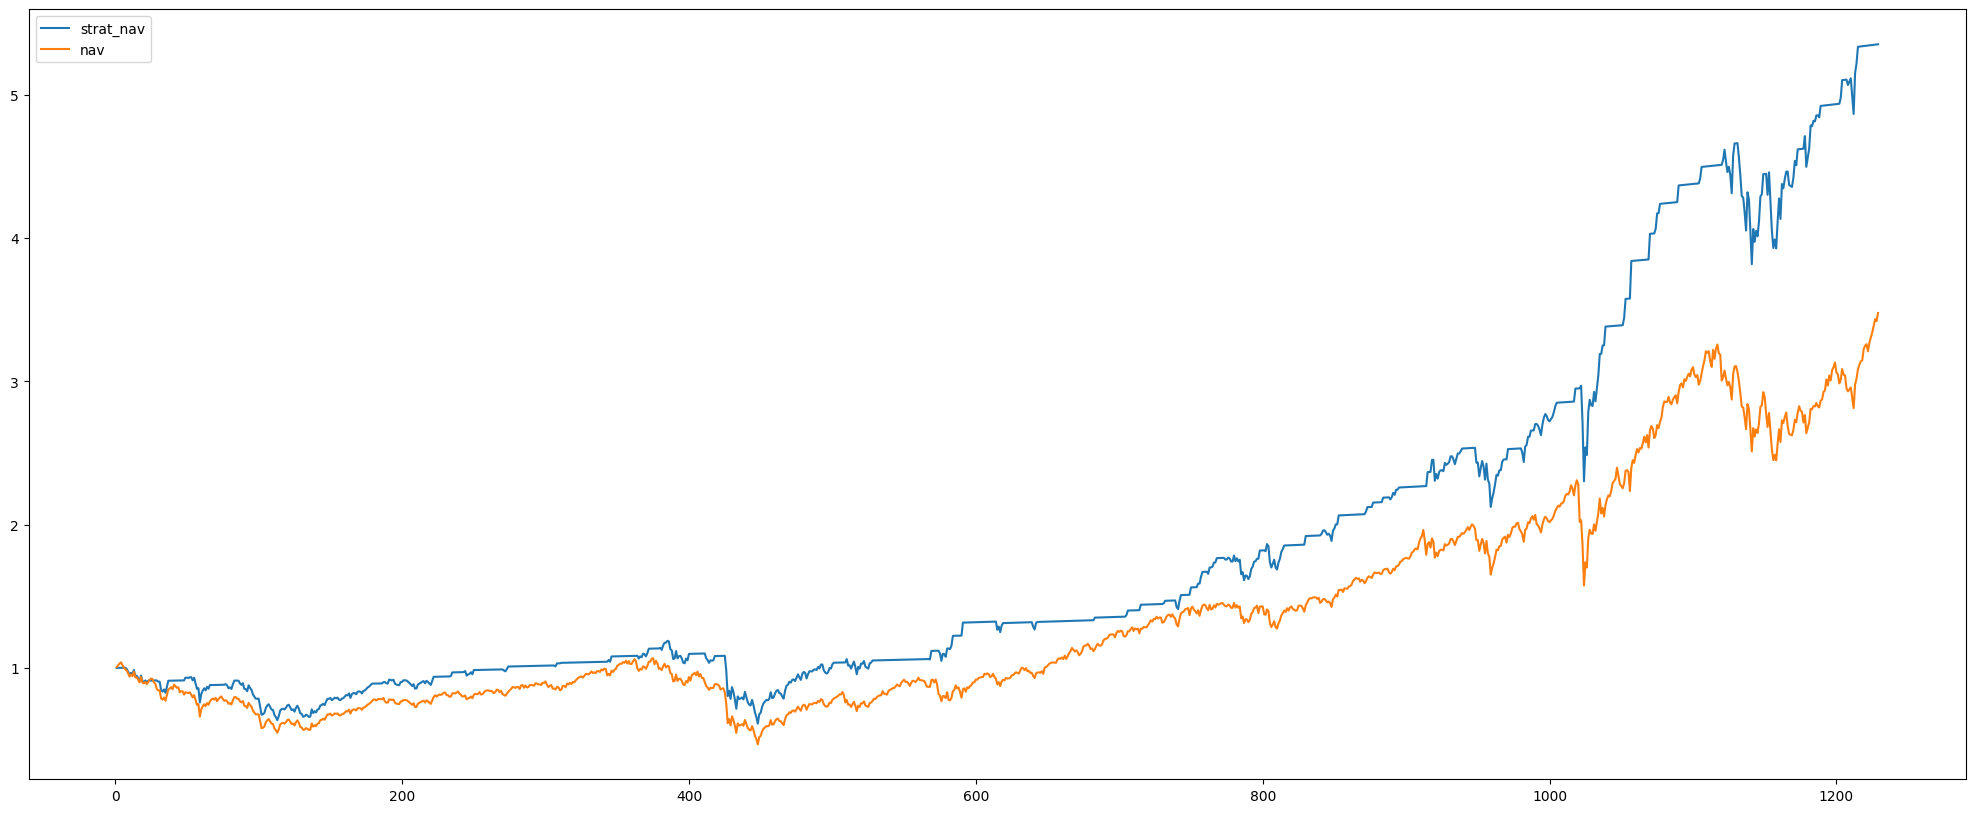

In [92]:
predictions_df[['strat_nav','nav']].plot(figsize=(25,10))